#**Cow Weight Prediction From Image Using Machine Learning**

##**Mounting**

In [4]:
import os
import google.colab
import time
import sys

# mounting Google Drive in the runtime's virtual machine

if not os.path.isdir('/content/drive'):

    google.colab.drive.mount('/content/drive')

Mounted at /content/drive


##**Installations & Imports**

In [5]:
import os
import csv
import joblib
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import mean_squared_error, mean_absolute_error

##**Initializations**

In [12]:
root_directory = '/content/drive/MyDrive/cattle project 2'
input_directory = '/content/drive/MyDrive/cattle project 2/input directory'
input_side_directory = '/content/drive/MyDrive/cattle project 2/input directory/side'
input_rear_directory = '/content/drive/MyDrive/cattle project 2/input directory/rear'
test_directory = '/content/drive/MyDrive/cattle project 2/test_directory'
side_test_directory = '/content/drive/MyDrive/cattle project 2/test_directory/side'
rear_test_directory = '/content/drive/MyDrive/cattle project 2/test_directory/rear'

##**Dataset Loading**

###**Extracting images from files and Image labeling**

In [ ]:
side_image_filenames = sorted(os.listdir(input_side_directory))
rear_image_filenames = sorted(os.listdir(input_rear_directory))

# Checking corresponding files and removing unmatched files
matched_side_images = []
matched_rear_images = []

print("Checking corresponding files...\n")

for side_image, rear_image in zip(side_image_filenames, rear_image_filenames):
    side_prefix = '_'.join(side_image.split('_')[:2])
    rear_prefix = '_'.join(rear_image.split('_')[:2])

    if side_prefix == rear_prefix:
        matched_side_images.append(side_image)
        matched_rear_images.append(rear_image)
    else:
        print(f"Unmatched: Side Image: {side_image} | Rear Image: {rear_image}")

side_image_filenames = matched_side_images
rear_image_filenames = matched_rear_images

if not side_image_filenames:
    print("No matched images found.")
else:
    print("\nRemaining matched images:")
    for side_image, rear_image in zip(side_image_filenames, rear_image_filenames):
        print(f"Side Image: {side_image} | Rear Image: {rear_image}")

Checking corresponding files...


Remaining matched images:
Side Image: 100_b4-1_s_124_F.jpg___fuse.png | Rear Image: 100_b4-1_r_124_F.jpg___fuse.png
Side Image: 100_b4-2_s_149_F.jpg___fuse.png | Rear Image: 100_b4-2_r_149_F.jpg___fuse.png
Side Image: 100_b4-3_s_142_F.jpg___fuse.png | Rear Image: 100_b4-3_r_142_F.jpg___fuse.png
Side Image: 100_b4-4_s_136_M.jpg___fuse.png | Rear Image: 100_b4-4_r_136_M.jpg___fuse.png
Side Image: 101_b4-1_s_124_F.jpg___fuse.png | Rear Image: 101_b4-1_r_124_F.jpg___fuse.png
Side Image: 101_b4-2_s_149_F.jpg___fuse.png | Rear Image: 101_b4-2_r_149_F.jpg___fuse.png
Side Image: 101_b4-3_s_142_F.jpg___fuse.png | Rear Image: 101_b4-3_r_142_F.jpg___fuse.png
Side Image: 101_b4-4_s_136_F.jpg___fuse.png | Rear Image: 101_b4-4_r_136_F.jpg___fuse.png
Side Image: 102_b4-1_s_124_F.jpg___fuse.png | Rear Image: 102_b4-1_r_124_F.jpg___fuse.png
Side Image: 102_b4-2_s_188_F.jpg___fuse.png | Rear Image: 102_b4-2_r_188_F.jpg___fuse.png
Side Image: 102_b4-3_s_142_F.jpg___fuse.

In [ ]:
# Initialize a dictionary to store the mapping of image filenames to weights
side_image_weights_mapping = {}
rear_image_weights_mapping = {}

for side_image, rear_image in zip(side_image_filenames, rear_image_filenames):

    weight = float(side_image.split('_')[3])
    side_image_weights_mapping[side_image] = weight
    rear_image_weights_mapping[rear_image] = weight

# Check the mapping of image filenames to weights
print('Total number of side images: {0}'.format(len(side_image_weights_mapping)))
print('Total number of rear images: {0}'.format(len(rear_image_weights_mapping)))

Total number of side images: 1828
Total number of rear images: 1828


###**Saving the image name and wight to the CSV file**

In [ ]:
# # Provide the filename for the CSV file to store the mapping
# csv_file_name = 'cow_weights_mapping.csv'

# csv_file_path = os.path.join(root_directory, csv_file_name)  # Update the desired CSV file path

# # Save the mapping to the CSV file
# with open(csv_file_path, 'w', newline='') as csvfile:
#     csv_writer = csv.writer(csvfile)
#     csv_writer.writerow(['Image Filename', 'Weight'])
#     for filename, weight in side_image_weights_mapping.items():
#         csv_writer.writerow([filename, weight])

# # Check if the CSV file exists and read its contents
# print("First 10 rows of the CSV file: \n")

# if os.path.exists(csv_file_path):
#     with open(csv_file_path, 'r') as csvfile:
#         csv_reader = csv.reader(csvfile)
#         i = 0
#         for row in csv_reader:
#             print(row)
#             if(i==10):
#               break;
#             i+=1
# else:
#     print("CSV file does not exist.")

First 10 rows of the CSV file: 

['Image Filename', 'Weight']
['857_172.jpg', '172.0']
['1417_138.jpg', '138.0']
['1368_141.jpg', '141.0']
['803_122.jpg', '122.0']
['1364_180.jpg', '180.0']
['1366_87.jpg', '87.0']
['367_104.jpg', '104.0']
['1990_143.jpg', '143.0']
['723_131.jpg', '131.0']
['711_82.jpg', '82.0']


###**Display some sample images**

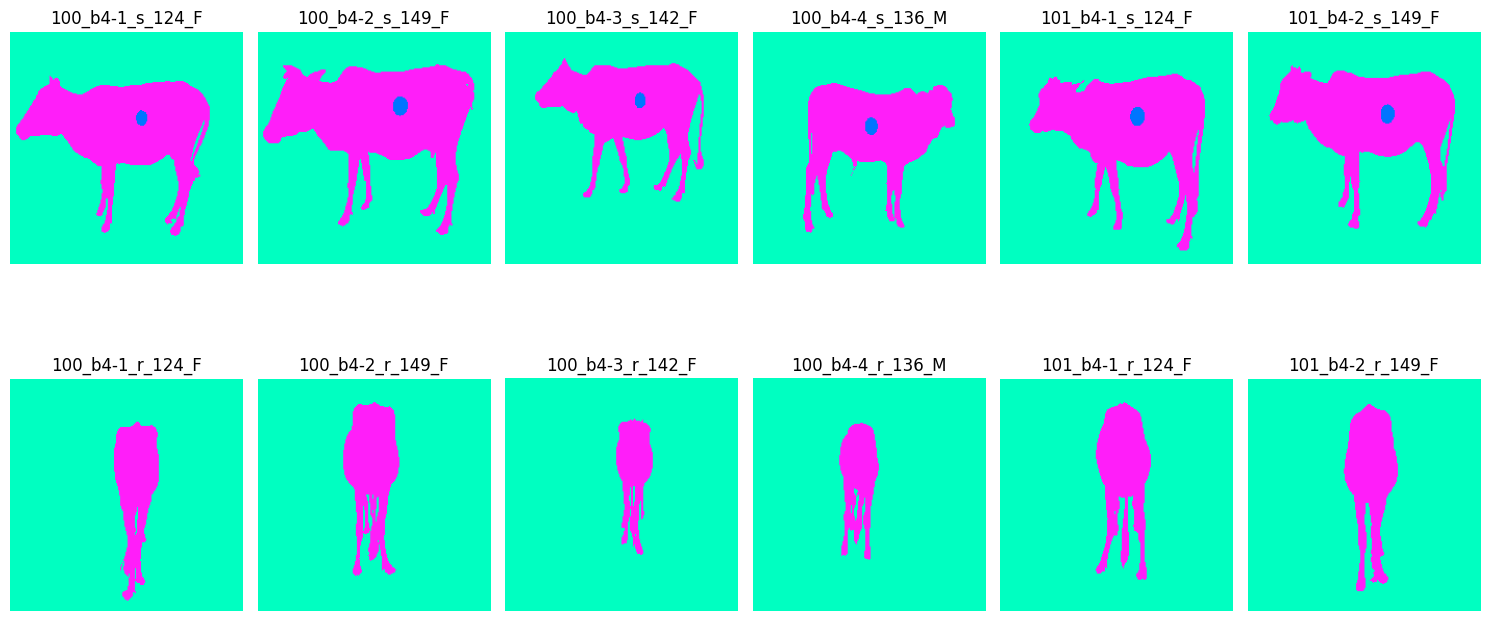

In [ ]:
num_pairs = 6  # Number of pairs to plot

plt.figure(figsize=(15, 8))

for i in range(num_pairs):
    side_filename = side_image_filenames[i]
    rear_filename = rear_image_filenames[i]

    side_image_path = os.path.join(input_side_directory, side_filename)
    rear_image_path = os.path.join(input_rear_directory, rear_filename)

    side_img = tf.keras.preprocessing.image.load_img(side_image_path, target_size=(224, 224))
    rear_img = tf.keras.preprocessing.image.load_img(rear_image_path, target_size=(224, 224))

    plt.subplot(2, num_pairs, i + 1)
    plt.imshow(side_img)
    plt.title(f"{side_filename.split('.')[0]}")
    plt.axis('off')

    plt.subplot(2, num_pairs, num_pairs + i + 1)
    plt.imshow(rear_img)
    plt.title(f"{rear_filename.split('.')[0]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Feature Extraction**

In [ ]:
# Step 1: Load the VGG16 model (without the classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Preprocess Input Images
def preprocess_images(image_path1, image_path2):
    img1 = load_and_preprocess_image(image_path1)
    img2 = load_and_preprocess_image(image_path2)
    return img1, img2

def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = preprocess_input(img)
    return img

# Step 3: Extract Features
def extract_features(image_path1, image_path2, model):
    img1, img2 = preprocess_images(image_path1, image_path2)
    img1 = np.expand_dims(img1, axis=0)  # Add a batch dimension
    img2 = np.expand_dims(img2, axis=0)  # Add a batch dimension
    features1 = model.predict(img1)
    features2 = model.predict(img2)
    return features1, features2

# Initialize a dictionary to store image filenames and their corresponding features
image_features = []

# Extract features for corresponding pairs of images
for side_filename, rear_filename in zip(side_image_filenames, rear_image_filenames):
    side_image_path = os.path.join(input_side_directory, side_filename)
    rear_image_path = os.path.join(input_rear_directory, rear_filename)

    side_features, rear_features = extract_features(side_image_path, rear_image_path, base_model)
    image_features.append([side_features, rear_features])

1/1 [==============================] - 0s 19ms/step


In [ ]:
# To get the features of an image, you can use:

# image_filename = random.choice(sample_images)
# features_of_image = image_features_mapping[image_filename]

# features_of_image

In [ ]:
# Convert the features from the dictionary to a numpy array
features_array = np.array(image_features)

# Get the corresponding cow weights (target variable y)
cow_weights = np.array(list(side_image_weights_mapping.values()))

# Data Preparation
X = features_array.reshape(features_array.shape[0], -1)  # Flatten the features for each image
y = cow_weights

print('Shape of features_array: {0}'.format(features_array.shape))
print('Shape of X: {0}'.format(X.shape))
print('Shape of y: {0}'.format(y.shape))

Shape of features_array: (1828, 2, 1, 7, 7, 512)
Shape of X: (1828, 50176)
Shape of y: (1828,)


##**Splitting the Dataset**

In [ ]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Number of train images: {0}'.format(len(X_train)))
print('Number of test images: {0}'.format(len(X_test)))

Number of train images: 1462
Number of test images: 366


## **Constructing RandomForestRegressor Model**

###**Train the model**

In [ ]:
#Mean Squared Error (MSE): 1366.6926296714273
#Mean Absolute Error (MAE): 28.543421797004992

# Model Selection (Random Forest Regression)
regressor_model = RandomForestRegressor(random_state=42)

history = regressor_model.fit(X_train, y_train)

###**Evaluate the model**

Training MAE: 8.144186046511628
Training RMSE: 10.289974820462174
Validation MAE: 23.297622950819672
Validation RMSE: 28.50493830765991


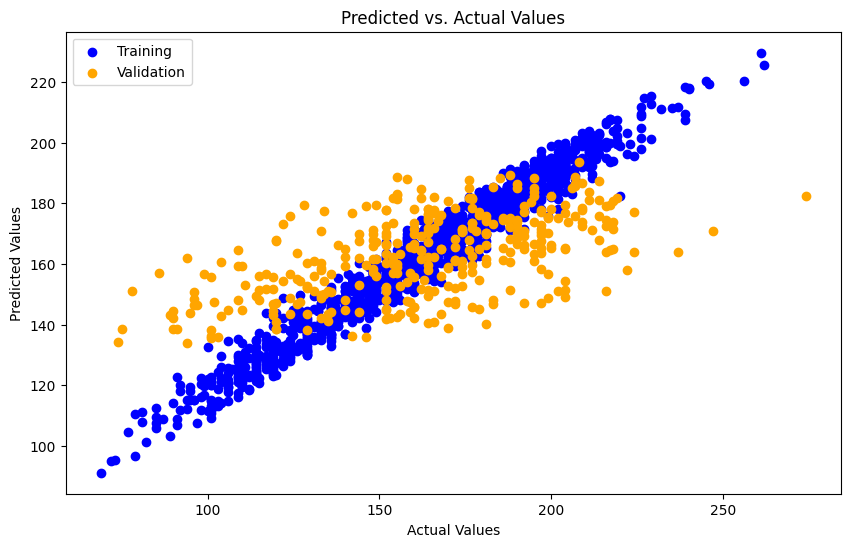

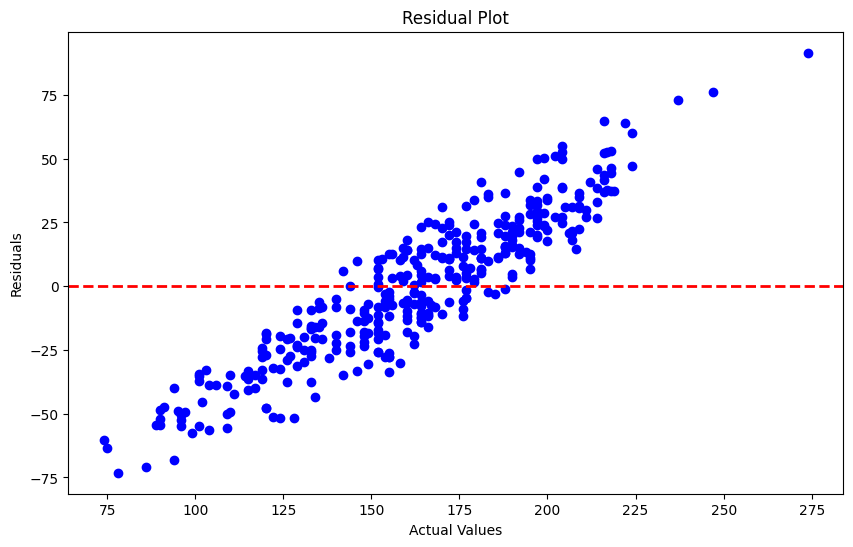

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Make predictions on the training and validation sets
train_predictions = regressor_model.predict(X_train)
val_predictions = regressor_model.predict(X_test)

# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)

val_mae = mean_absolute_error(y_test, val_predictions)
val_mse = mean_squared_error(y_test, val_predictions)
val_rmse = np.sqrt(val_mse)

print("Training MAE:", train_mae)
print("Training RMSE:", train_rmse)
print("Validation MAE:", val_mae)
print("Validation RMSE:", val_rmse)

# Create scatter plots to compare predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_predictions, color='blue', label='Training')
plt.scatter(y_test, val_predictions, color='orange', label='Validation')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.show()

# Create a line plot to visualize the residuals
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_test - val_predictions, 'o', color='blue', markersize=6)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='red', linewidth=2, linestyle='--')
plt.show()

###**Save the model**

In [ ]:
# Save the trained model to a file
name = 'model-vgg-rf.joblib'
model_path = os.path.join(root_directory, name)

print('Model path:', end=' ')
joblib.dump(regressor_model, model_path)

Model path: 

['/content/drive/MyDrive/cattle project 2/model-vgg-rf.joblib']

##**Prediction Using Model**

In [13]:
# Load the pre-trained VGG16 model (without classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_path = '/content/drive/MyDrive/cattle project 2/model-vgg-rf.joblib'

# Load the trained Random Forest Regressor model
with open(model_path, 'rb') as file:
    regressor_model = joblib.load(file)

# Path to the folder containing five new images
side_test_image_list = sorted(os.listdir(side_test_directory))
rear_test_image_list = sorted(os.listdir(rear_test_directory))

# Checking corresponding files and removing unmatched files
matched_side_images = []
matched_rear_images = []

print("Checking corresponding files...\n")

for side_image, rear_image in zip(side_test_image_list, rear_test_image_list):
    side_prefix = '_'.join(side_image.split('_')[:2])
    rear_prefix = '_'.join(rear_image.split('_')[:2])

    if side_prefix == rear_prefix:
        matched_side_images.append(side_image)
        matched_rear_images.append(rear_image)
    else:
        print(f"Unmatched: Side Image: {side_image} | Rear Image: {rear_image}")

side_test_image_list = matched_side_images
rear_test_image_list = matched_rear_images

if not side_test_image_list:
    print("No matched images found.")
else:
    print("\nRemaining matched images:")
    for side_image, rear_image in zip(side_test_image_list, rear_test_image_list):
        print(f"Side Image: {side_image} | Rear Image: {rear_image}")

Checking corresponding files...


Remaining matched images:
Side Image: 1_b4-1_s_69_F.jpg___fuse.png | Rear Image: 1_b4-1_r_69_F.jpg___fuse.png
Side Image: 1_b4-2_s_78_F.jpg___fuse.png | Rear Image: 1_b4-2_r_78_F.jpg___fuse.png
Side Image: 1_b4-3_s_87_M.jpg___fuse.png | Rear Image: 1_b4-3_r_87_M.jpg___fuse.png
Side Image: 1_b4-4_s_72_M.jpg___fuse.png | Rear Image: 1_b4-4_r_72_M.jpg___fuse.png


In [14]:
def preprocess_images(image_path1, image_path2):
    img1 = load_and_preprocess_image(image_path1)
    img2 = load_and_preprocess_image(image_path2)
    return img1, img2

def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = preprocess_input(img)
    return img

def extract_features(image_path1, image_path2, model):
    img1, img2 = preprocess_images(image_path1, image_path2)
    img1 = np.expand_dims(img1, axis=0)  # Add a batch dimension
    img2 = np.expand_dims(img2, axis=0)  # Add a batch dimension
    features1 = model.predict(img1)
    features2 = model.predict(img2)
    return features1, features2

In [15]:
# Initialize a list to store the predictions for five images
prediction_list = []
image_features = []
side_image_weights_mapping = {}

# Extract features for corresponding pairs of images
for side_filename, rear_filename in zip(side_test_image_list, rear_test_image_list):
    side_image_path = os.path.join(side_test_directory, side_filename)
    rear_image_path = os.path.join(rear_test_directory, rear_filename)

    true_weight = float(side_filename.split('_')[3])
    prediction_list.append((side_image_path, true_weight))

    side_features, rear_features = extract_features(side_image_path, rear_image_path, base_model)
    image_features.append([side_features, rear_features])

    weight = float(side_filename.split('_')[3])
    side_image_weights_mapping[side_image] = weight

features_array = np.array(image_features)

cow_weights = np.array(list(side_image_weights_mapping.values()))

X = features_array.reshape(features_array.shape[0], -1)  # Flatten the features for each image

y = cow_weights

weight_prediction = regressor_model.predict(X)

1/1 [==============================] - 0s 85ms/step


In [16]:
weight_prediction

array([ 91.17, 151.14, 108.78,  94.95])

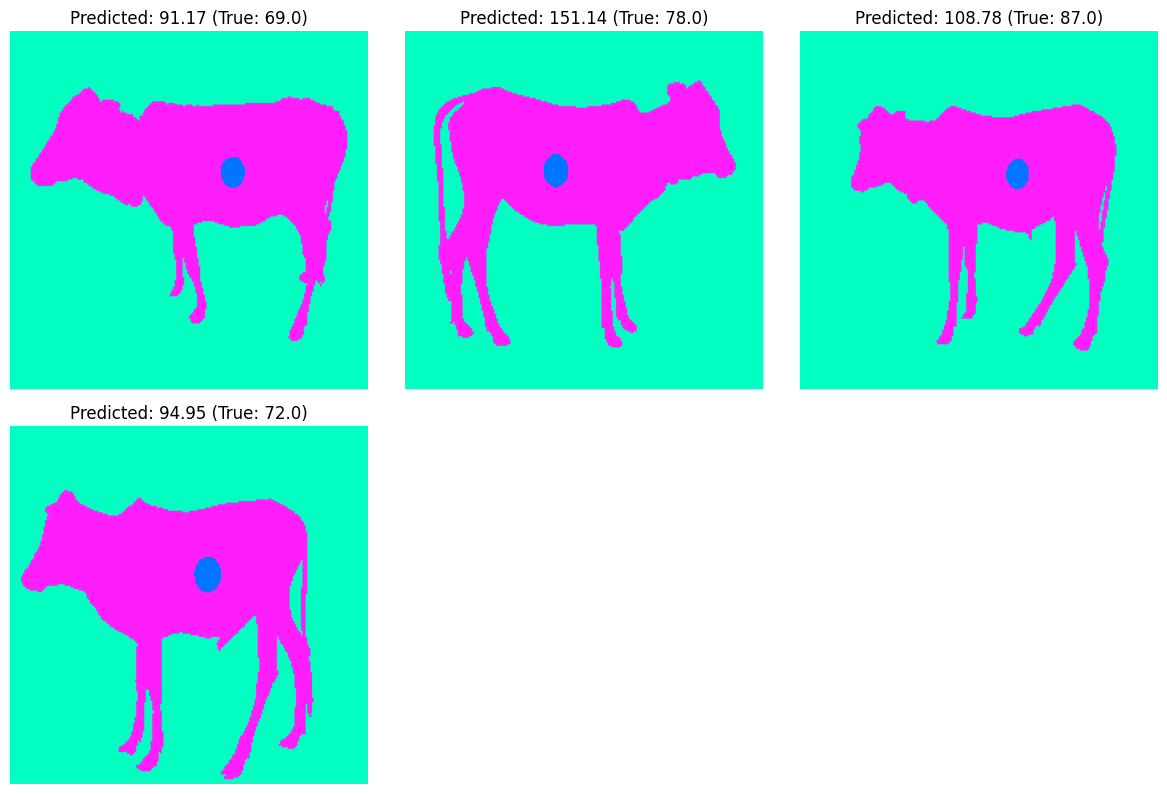

In [17]:
# Show the predictions for six images in a 3x3 grid layout
plt.figure(figsize=(12, 12))
k = 0
for i, (image_path, true_weight) in enumerate(prediction_list[:9]):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title("Predicted: {0} (True: {1})".format(weight_prediction[k], true_weight))
    plt.axis('off')
    k+=1

plt.tight_layout()
plt.show()